In [ ]:
!pip install --quiet torchmetrics datasets tqdm dotenv wikidata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import math
import json
import os

from huggingface_hub import hf_hub_download

import sklearn
import sklearn.svm as sksvm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import F1Score, Recall, Precision

import matplotlib.pyplot as plt

import datasets

from tqdm import tqdm

import joblib

from dotenv import load_dotenv

from google.colab import drive as drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Pizza_Language_&_Mandolino_shared_folder')


In [ ]:
import utilsLib as utils

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Note
Traing has 3 settings:
- 0: will use the models already trained sotred in /Pizza_Language_&_Mandolino_shared_folder/pretrained_models
- 1: will retrain the models using the best iperparameters we found during grid search
- 2: will retrain the model executing grid search. The only excetion is the praragraph model due to the time requirementes of a single traing loop

With TRAINING > 0 the new models are saved in /Pizza_Language_&_Mandolino_shared_folder/new_models the last cell of the notebook, which is set on false by default will move the models from /new_models to pretrained models

In [ ]:

load_dotenv()
SEED = 42
TRAINING = 0

sklearn.random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
FILE_MOUNT = "./drive/MyDrive/Pizza_Language_&_Mandolino_shared_folder"
# Load encodings
UTILS_PATH = 'utils'
ENCODINGS_NAME = {
    "subcategory":"subcategoriesAliases.json",
    "category":"categoriesAliases.json",
    "label":"labelsAliases.json",
    "type":"typesAliases.json",
}

# Ensemble Submodules paths
MODELS_PATH = "pretrained_models"
NEW_MODELS_PATH='new_models'
SVC_CATEGORIES_NAME = 'categorySVCWeights.pkl'
SVC_DESCRIPTION_NAME = 'DescriptionSVM.pkl'
SVC_PARAGRAPH_NAME = 'PenaltySVM_OOV.pkl'
LINEAR_WEIGHTS = "decisorWeights.pth"

In [ ]:
# if 'pretrained_models' not in os.listdir('.'):
#     os.makedirs('./pretrained_models')
#     for i in [SVC_CATEGORIES_NAME, SVC_CATEGORIES_NAME, SVM_PARAGRAPH_NAME]:
#         hf_hub_download(repo_id=os.environ['HF_REPO'],
#                         filename=i,
#                         local_dir=MODELS_PATH,
#                         token=HF_TOKEN,
#                         repo_type='model')
# else:
#     for i in [SVC_CATEGORIES_NAME, SVC_CATEGORIES_NAME, SVM_PARAGRAPH_NAME]:
#         if i not in os.listdir(MODELS_PATH):
#             hf_hub_download(repo_id=os.environ['HF_REPO'],
#                             filename=i,
#                             local_dir=MODELS_PATH,
#                             token=HF_TOKEN,
#                             repo_type='model')

In [ ]:
encodings = dict()
for key in ENCODINGS_NAME:
    with open(f'{FILE_MOUNT}/{UTILS_PATH}/{ENCODINGS_NAME[key]}', 'r') as file:
        encodings[key] = json.load(file)

encoding2label = {v:k for k,v in encodings['label'].items()}
print(encoding2label)

{0: 'cultural exclusive', 1: 'cultural agnostic', 2: 'cultural representative'}


### Dataset assembly

In [ ]:
datasetTraining = pd.read_csv(f"{FILE_MOUNT}/{UTILS_PATH}/trainsetTotal.csv")
datasetValidation = pd.read_csv(f"{FILE_MOUNT}/{UTILS_PATH}/valsetTotal.csv")
datasetEvaluation = pd.read_csv(f'{FILE_MOUNT}/test_unlabeled.csv')

In [ ]:
dTrain = datasetTraining
unblancedWeights = {
    0: dTrain.shape[0]/(dTrain[dTrain['label'] == encoding2label[0]].shape[0]*3),
    1: dTrain.shape[0]/(dTrain[dTrain['label'] == encoding2label[1]].shape[0]*3),
    2: dTrain.shape[0]/(dTrain[dTrain['label'] == encoding2label[2]].shape[0]*3)
}

In [ ]:
def baseInfoDataset(dataset, encodings, debug=False):
    subcategoriesColumn = np.zeros((dataset.shape[0], len(encodings['subcategory'].keys())), dtype=int)
    categoriesColumn = np.zeros((dataset.shape[0], len(encodings['category'].keys())), dtype=int)
    typesColumn = np.zeros((dataset.shape[0], len(encodings['type'].keys())), dtype=int)
    for i in range(dataset.shape[0]):
        try:
            subcategoriesColumn[i][encodings['subcategory'][dataset['subcategory'].iloc[i]]] = 1
        except KeyError:
            pass
        try:
            categoriesColumn[i][encodings['category'][dataset['category'].iloc[i]]] = 1
        except KeyError:
            pass
        try:
            typesColumn[i][encodings['type'][dataset['type'].iloc[i]]] = 1
        except KeyError:
            pass
    if debug:
        print(subcategoriesColumn.shape)
        print(categoriesColumn.shape)
        print(typesColumn.shape)

    return np.concatenate(
        (subcategoriesColumn,categoriesColumn,typesColumn),
        axis=1
    )

#### Note:
The weights coming form mostInfluentWords  are no longer used, now we uses a flat 0.3 penalization

In [ ]:
def paragraphDataset(testSet, trainSet, valSet, cache):
    columsToEncode = ['type', 'subcategory']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    test = testSet.copy()
    train = trainSet.copy()
    validation = valSet.copy()
    trainEncodingTS = encoder.fit_transform(train[columsToEncode]).astype(float)
    testEncodingTS = encoder.transform(test[columsToEncode]).astype(float)
    valEncodingTS = encoder.transform(validation[columsToEncode]).astype(float)

    UNK_TOKEN = '<UNK>'
    processor = utils.ParagraphProcessor(f'{FILE_MOUNT}/utils/mostInfluentWords.json',
                                            removed=['ˈ', 'also', 'since', 'many'],
                                            unkonwn=UNK_TOKEN)

    if cache is not None:
        if len(cache['train']) > 0:
            paragraphsTr = cache['train']
            print("Training cached")
        else:
            print("Download Train")
            paragraphsTr = utils.getText(train, lang='en', max_workers=10)
            print("Result:", paragraphsTr)

        if len(cache['test']) > 0:
            paragraphsTe = cache['test']
            print("Test cached")
        else:
            print("Download Test")
            paragraphsTe = utils.getText(test, lang='en', max_workers=10)
            print("Result:", paragraphsTe)

        if len(cache['val']) > 0:
            paragraphsVa = cache['val']
            print("Validation cached")
        else:
            print("Download Validation")
            paragraphsVa = utils.getText(validation, lang='en', max_workers=10)
            print("Result:", paragraphsVa)

    else:
        print("Download Train")
        paragraphsTr = utils.getText(train, lang='en', max_workers=10)
        print("Result:", paragraphsTr)
        print("Download Test")
        paragraphsTe = utils.getText(test, lang='en', max_workers=10)
        print("Result:", paragraphsTe)
        print("Download Validation")
        paragraphsVa = utils.getText(validation, lang='en', max_workers=10)
        print("Result:", paragraphsVa)

    cache['train'] = paragraphsTr
    train['paragraph'] = paragraphsTr
    cache['test'] = paragraphsTe
    test['paragraph'] = paragraphsTe
    cache['val'] = paragraphsVa
    validation['paragraph'] = paragraphsVa

    testEncodingTFIDF, trainEncodingTFIDF, valEncodingTFIDF = processor.process(test, validation, train)

    testData = np.hstack([testEncodingTFIDF, testEncodingTS])
    trainData = np.hstack([trainEncodingTFIDF, trainEncodingTS])
    valData = np.hstack([valEncodingTFIDF, valEncodingTS])
    return testData, trainData, valData

In [ ]:
def descriptionDataset(testSet, trainSet, valSet, debug=False):
    UNK_TOKEN = '<UNK>'
    test = testSet.copy()
    train = trainSet.copy()
    valid = valSet.copy()
    columsToEncode = ['type', 'subcategory']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    trainEncodingTS = encoder.fit_transform(train[columsToEncode]).astype(float)
    testEncodingTS = encoder.transform(test[columsToEncode]).astype(float)
    validEncodingTS = encoder.transform(valid[columsToEncode]).astype(float)
    processor = utils.DescriptionProcessor(None,
                                            removed=['ˈ', 'also', 'since', 'many'],
                                            unkonwn=UNK_TOKEN)

    testEncodingTFIDF, trainEncodingTFIDF, validEncodingTFIDF = processor.process(test,train,valid)

    if debug:
        print(testEncodingTFIDF.shape)
        print(testEncodingTS.shape)
    testData = np.hstack([testEncodingTFIDF, testEncodingTS])

    if debug:
        print(trainEncodingTFIDF.shape)
        print(trainEncodingTS.shape)
    trainData = np.concatenate((trainEncodingTFIDF, trainEncodingTS), axis=1)

    if debug:
        print(validEncodingTFIDF.shape)
        print(validEncodingTS.shape)
    validData = np.concatenate((validEncodingTFIDF, validEncodingTS), axis=1)
    return testData, trainData, validData

In [ ]:
baseDataTest = baseInfoDataset(datasetEvaluation, encodings)
baseDataTrain = baseInfoDataset(datasetTraining, encodings)
baseDataVal = baseInfoDataset(datasetValidation, encodings)

## Cache mechanism for the paragraphs
The paragraph classification model requires to download the first paragraph from each wikipedia page. This is a time consuming process so we have stored the paragraphs in json files divided in training, test and validation. They can be found in the utils directory

### Warning
Removing the cache for the training set will require the retraining of the paragraph SVC because the takedown of wikipedia pages causes variation in the size of the encoding vector

In [ ]:
paragraphCache = {'test': [], 'train': [], 'val': []}

In [ ]:
for k in ['test', 'train', 'val']:
    with open(f"{FILE_MOUNT}/{UTILS_PATH}/{k}Cache.json", 'r') as f:
        try:
            paragraphCache[k] = json.load(f)
            print(f"{k} -> {paragraphCache[k]}")
        except Exception:
            paragraphCache[k] = []
            print(f"{k} -> {paragraphCache[k]}")
        f.close()

for k in paragraphCache:
    print(f"{k} -> {paragraphCache[k]}")

test -> ["The Northeast Flag Replacement ( traditional Chinese : 東北易幟 ; simplified Chinese : 东北易帜 ; pinyin : Dōngběi Yìzhì ) refers to Zhang Xueliang 's announcement on 29 December 1928 that all banners of the Beiyang government in Manchuria would be replaced with the flag of the Nationalist government , thus nominally uniting China under one government.", "Imam ( / ɪ ˈ m ɑː m / ; Arabic : إمام , imām ; pl. : أئمة , a'immah ) is an Islamic leadership position. For Sunni Muslims , Imam is most commonly used as the title of a prayer leader of a mosque . In this context, imams may lead Islamic prayers , serve as community leaders, and provide religious guidance. Thus for Sunnis, anyone can study the basic Islamic teachings and become an imam.", "Fußball-Club Bayern München e. V. ( FCB , German pronunciation: [ˈfuːsbalˌklʊp ˈbaɪɐn ˈmʏnçn̩] ), commonly known as Bayern Munich ( German : Bayern München ), FC Bayern ( pronounced [ˌɛft͡seː ˈbaɪɐn] ⓘ ) or simply Bayern , is a German professional

In [ ]:
paragraphDataTest, paragraphDataTrain, paragraphDataVal = paragraphDataset(datasetEvaluation,datasetTraining, datasetValidation, paragraphCache)
print(paragraphDataTest.shape)
print(paragraphDataTrain.shape)
print(paragraphDataVal.shape)

100%|██████████| 300/300 [00:00<00:00, 584.81it/s]


(300, 38056)
(6251, 38056)
(300, 38056)


In [ ]:
for k in paragraphCache:
    print(f"{k} -> {paragraphCache[k]}")

test -> ["The Northeast Flag Replacement ( traditional Chinese : 東北易幟 ; simplified Chinese : 东北易帜 ; pinyin : Dōngběi Yìzhì ) refers to Zhang Xueliang 's announcement on 29 December 1928 that all banners of the Beiyang government in Manchuria would be replaced with the flag of the Nationalist government , thus nominally uniting China under one government.", "Imam ( / ɪ ˈ m ɑː m / ; Arabic : إمام , imām ; pl. : أئمة , a'immah ) is an Islamic leadership position. For Sunni Muslims , Imam is most commonly used as the title of a prayer leader of a mosque . In this context, imams may lead Islamic prayers , serve as community leaders, and provide religious guidance. Thus for Sunnis, anyone can study the basic Islamic teachings and become an imam.", "Fußball-Club Bayern München e. V. ( FCB , German pronunciation: [ˈfuːsbalˌklʊp ˈbaɪɐn ˈmʏnçn̩] ), commonly known as Bayern Munich ( German : Bayern München ), FC Bayern ( pronounced [ˌɛft͡seː ˈbaɪɐn] ⓘ ) or simply Bayern , is a German professional

In [ ]:
for i in ['test', 'train', 'val']:
    with open(f'{FILE_MOUNT}/{UTILS_PATH}/{i}Cache.json', 'w+', encoding='utf-8') as f:
        json.dump(paragraphCache[i], f)
        f.close()

In [ ]:
descriptionDataTest,descriptionDataTrain,descriptionDataValid  = descriptionDataset(datasetEvaluation, datasetTraining, datasetValidation)
print(descriptionDataTest.shape)
print(descriptionDataTrain.shape)
print(descriptionDataValid.shape)

100%|██████████| 300/300 [00:00<00:00, 4195.34it/s]


(300, 6642)
(6251, 6642)
(300, 6642)


In [ ]:
labelsTrain = datasetTraining['label'].apply(lambda x: encodings['label'][x])
labelsValid = datasetValidation['label'].apply(lambda x: encodings['label'][x])
print(labelsTrain.shape)
print(labelsValid.shape)

(6251,)
(300,)


# Model Training

#### Base Information Model training
This model predicts the odds of a sample belonging to a class based on the values of type, category and subcategory

In [ ]:
bestScore = 0
bestModel = None

if TRAINING == 2:
    gammaCandidates = np.linspace(0.1,1,10)
    cCandidates = np.linspace(1,10,10)
    kernels = ['rbf']
    for gamma,c, k in tqdm(product(gammaCandidates, cCandidates, kernels)):
        try:
            model =  sksvm.SVC(C=c, gamma=gamma, kernel=k, max_iter=10000, probability=True, class_weight=unblancedWeights)
            model.fit(baseDataTrain, labelsTrain)
            score = accuracy_score(model.predict(baseDataVal), labelsValid)
            if score > bestScore:
                bestModel = model
                bestScore = score
        except Exception as e:
            print(f"ERROR! Params:\tC={c}, gamma={gamma}, kernel={k}: {e}")
    baseInfoModel = bestModel
    joblib.dump(baseInfoModel, f'{NEW_MODELS_PATH}/{SVC_CATEGORIES_NAME}')

elif TRAINING == 1:
    c = 4.0
    gamma = 0.1
    k = 'rbf'
    model =  sksvm.SVC(C=c, gamma=gamma, kernel=k, max_iter=10000, probability=True, class_weight=svmWeights)
    model.fit(baseDataTrain, labelsTrain)
    score = accuracy_score(model.predict(baseDataVal), labelsValid)
    baseInfoModel = model
    joblib.dump(baseInfoModel, f'{FILE_MOUNT}/{NEW_MODELS_PATH}/{SVC_CATEGORIES_NAME}')

else:
    baseInfoModel = joblib.load(f"{FILE_MOUNT}/{MODELS_PATH}/{SVC_CATEGORIES_NAME}")


print(baseInfoModel)

SVC(C=4.0,
    class_weight={0: 0.7743094264833396, 1: 1.1130698005698005,
                  2: 1.2343996840442337},
    gamma=0.1, max_iter=10000, probability=True)


In [ ]:
baseDataValPred = baseInfoModel.predict(baseDataVal)
print(f"Accuracy: {accuracy_score(baseDataValPred, labelsValid):.4f}")
print(f"F1 Score: {f1_score(baseDataValPred, labelsValid,average='weighted'):.4f}")
print(f"Recall: {recall_score(baseDataValPred, labelsValid, average='weighted'):.4f}")
print(f"Precision: {precision_score(baseDataValPred, labelsValid, average='weighted'):.4f}")

Accuracy: 0.6667
F1 Score: 0.6776
Recall: 0.6667
Precision: 0.7006


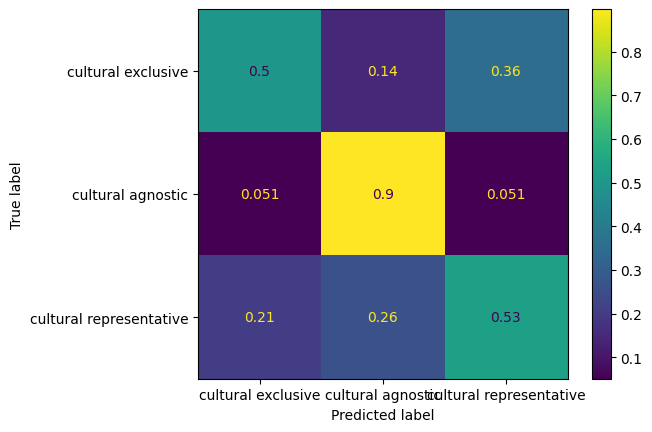

In [ ]:
cfm = confusion_matrix(y_true=labelsValid, y_pred=baseDataValPred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=[encoding2label[i] for i in range(3)])
disp.plot()
plt.show()

### Description Model training

In [ ]:
bestScore  = 0
bestModel  = None

if TRAINING == 2:
    C_vals = [5, 7, 10]
    gamma = 'scale'
    kernels = ['linear']
    for c, kernel in tqdm(product(C_vals, kernels)):
        svc = sksvm.SVC(C=c, gamma=gamma, kernel=kernel, class_weight=unblancedWeights, probability=True)
        try:
            svc.fit(descriptionDataTrain, labelsTrain)
            y_pred = svc.predict(descriptionDataValid)
            score = accuracy_score(labelsValid, y_pred)

            if score > bestScore:
                bestScore  = score
                bestModel  = svc
        except Exception as e:
            print(f"ERROR! Params:\tC={c}, gamma={gamma}, kernel={kernel}: {e}")
    descriptionModel = bestModel
    joblib.dump(descriptionModel,f"{FILE_MOUNT}/{NEW_MODELS_PATH}/{SVC_DESCRIPTION_NAME}")
elif TRAINING == 1:
    gamma = 'scale'
    k = 'linear'
    c = 7
    svc = sksvm.SVC(C=c, gamma=gamma, kernel=k, class_weight=svmWeights, probability=True)
    svc.fit(descriptionDataTrain, labelsTrain)
    y_pred = svc.predict(descriptionDataValid)
    score = accuracy_score(labelsValid, y_pred)
    descriptionModel = svc
    joblib.dump(descriptionModel,f"{FILE_MOUNT}/{NEW_MODELS_PATH}/{SVC_DESCRIPTION_NAME}")
else:
    descriptionModel = joblib.load(f"{FILE_MOUNT}/{MODELS_PATH}/{SVC_DESCRIPTION_NAME}")

print(descriptionModel)


SVC(C=7,
    class_weight={0: 0.7743094264833396, 1: 1.1130698005698005,
                  2: 1.2343996840442337},
    kernel='linear', probability=True)


In [ ]:
descriptionDataValPred=descriptionModel.predict(descriptionDataValid)
print(f"Accuracy: {accuracy_score(descriptionDataValPred, labelsValid):.4f}")
print(f"F1 Score: {f1_score(descriptionDataValPred, labelsValid,average='weighted'):.4f}")
print(f"Recall: {recall_score(descriptionDataValPred, labelsValid, average='weighted'):.4f}")
print(f"Precision: {precision_score(descriptionDataValPred, labelsValid, average='weighted'):.4f}")

Accuracy: 0.6700
F1 Score: 0.6671
Recall: 0.6700
Precision: 0.6748


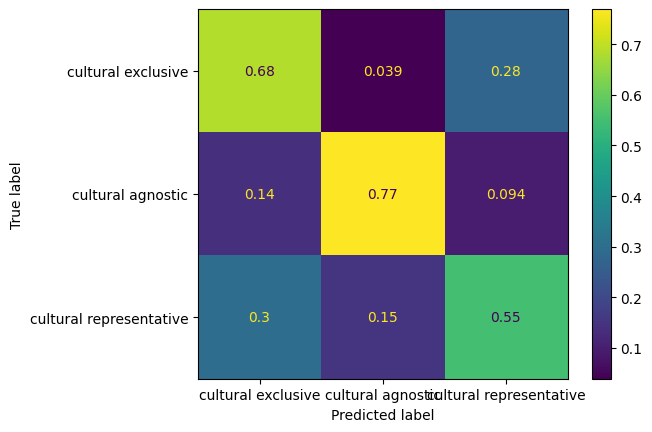

In [ ]:
cfm = confusion_matrix(y_true=labelsValid, y_pred=descriptionDataValPred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=[encoding2label[i] for i in range(3)])
disp.plot()
plt.show()

### Paragraph Model training
This model makes inference from the first paragraph of the wikipadia page of the item

In [ ]:
if TRAINING > 0:
    gamma = 'scale'
    c = 2
    kernel='linear'
    svc = sksvm.SVC(C=c, gamma=gamma, kernel=kernel, class_weight=unblancedWeights, probability=True, max_iter=5000)
    svc.fit(paragraphDataTrain, labelsTrain)
    score = accuracy_score(svc.predict(paragraphDataVal), labelsValid)
    paragraphModel = svc
    joblib.dump(paragraphModel,f"{FILE_MOUNT}/{NEW_MODELS_PATH}/{SVC_PARAGRAPH_NAME}")
else:
    paragraphModel = joblib.load(f"{FILE_MOUNT}/{MODELS_PATH}/{SVC_PARAGRAPH_NAME}")

print(paragraphModel)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=7,
    class_weight={0: 0.7743094264833396, 1: 1.1130698005698005,
                  2: 1.2343996840442337},
    kernel='linear', max_iter=1000, probability=True)


In [ ]:
paragraphDataValPred = paragraphModel.predict(paragraphDataVal)
print(f"Accuracy: {accuracy_score(paragraphDataValPred, labelsValid):.4f}")
print(f"F1 Score: {f1_score(paragraphDataValPred, labelsValid,average='weighted'):.4f}")
print(f"Recall: {recall_score(paragraphDataValPred, labelsValid, average='weighted'):.4f}")
print(f"Precision: {precision_score(paragraphDataValPred, labelsValid, average='weighted'):.4f}")

Accuracy: 0.6867
F1 Score: 0.6854
Recall: 0.6867
Precision: 0.6945


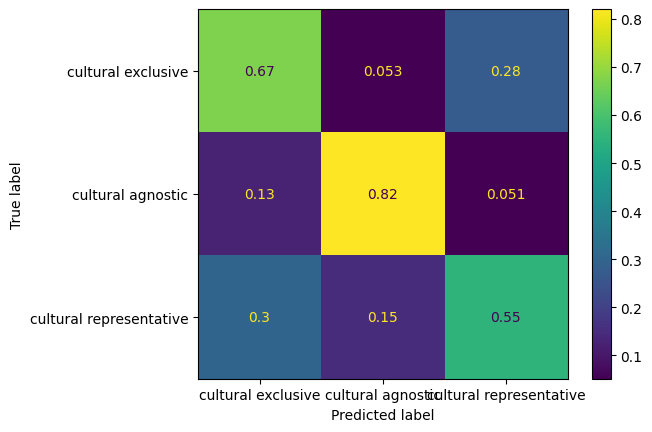

In [ ]:
cfm = confusion_matrix(y_true=labelsValid, y_pred=paragraphDataValPred, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=[encoding2label[i] for i in range(3)])
disp.plot()
plt.show()

In [ ]:
if ['trainX.npy', 'valX.npy'] in os.listdir(f"{FILE_MOUNT}/{UTILS_PATH}"):
    decisorTrainX = torch.load(f'{FILE_MOUNT}/{UTILS_PATH}/trainX.pt')
    decisorValX = torch.load(f'{FILE_MOUNT}/{UTILS_PATH}/valX.pt')

    decisorTrainY = torch.Tensor(labelsTrain).long()
    decisorValY = torch.Tensor(labelsValid).long()

else:
    print("Decisor Model Train/Validation sets construction... It may take a while")
    decisorBTrain = torch.Tensor(baseInfoModel.predict_proba(baseDataTrain)).float()
    decisorDTrain = torch.Tensor(descriptionModel.predict_proba(descriptionDataTrain)).float()
    decisorPTrain = torch.Tensor(paragraphModel.predict_proba(paragraphDataTrain)).float()

    print(decisorBTrain.shape,decisorDTrain.shape,decisorPTrain.shape)

    decisorTrainX = torch.concatenate((decisorBTrain, decisorDTrain, decisorPTrain), 1)

    decisorBVal = torch.Tensor(baseInfoModel.predict_proba(baseDataVal)).float()
    decisorDVal = torch.Tensor(descriptionModel.predict_proba(descriptionDataValid)).float()
    decisorPVal = torch.Tensor(paragraphModel.predict_proba(paragraphDataVal)).float()

    print(decisorBVal.shape,decisorDVal.shape,decisorPVal.shape)

    decisorValX = torch.concatenate((decisorBVal, decisorDVal, decisorPVal), 1)

    decisorTrainY = torch.Tensor(labelsTrain).long()
    decisorValY = torch.Tensor(labelsValid).long()

FileNotFoundError: [Errno 2] No such file or directory: 'utils'

In [ ]:
print(decisorTrainY.shape()[0])
print(decisorValY.shape()[0])

In [ ]:
torch.save(decisorTrainX, f'{FILE_MOUNT}/{UTILS_PATH}/trainX.pt')
torch.save(decisorValX, f'{FILE_MOUNT}/{UTILS_PATH}/valX.pt')

In [ ]:
decisorDataTrain = TensorDataset(decisorTrainX, decisorTrainY)
decisorDataValidation = TensorDataset(decisorValX, decisorValY)

trainSet = DataLoader(decisorDataTrain, shuffle=True, batch_size=64)
validationSet = DataLoader(decisorDataValidation, shuffle=True, batch_size=64)

### Voting strategy training

In [ ]:
TRAINING = 2

f1Scorer = F1Score(task="multiclass", num_classes=3, average='weighted').to(device)
precisionScorer = Precision(task='multiclass', num_classes=3, average='weighted').to(device)
recallScorer = Recall(task='multiclass', num_classes=3, average='weighted').to(device)


epochs = 50
patience = 10
bestScore = -float('inf')

if TRAINING == 2:
    learningRates = np.concatenate([np.linspace(float(f"1e-{i}"), float(f"1e-{i+1}"), 10) for i in range(0,3)])
    wCandidates = [float(f"1e-{n}") for n in range(2,6)]
    wCandidates.append(0)
    optimizers = ['adam', 'sgd']
    bestHParams = {}

elif TRAINING == 1:
    learningRates = [0.004]
    wCandidates = [0]
    optimizers = ['sgd']

if TRAINING > 0:
    weights = [unblancedWeights[i] for i in unblancedWeights.keys()]
    weights = torch.Tensor(weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    for o, l,w in tqdm(product(optimizers, learningRates, wCandidates)):
        cntPatience = 0
        model = nn.Linear(9,3, dtype=torch.float32)
        model = model.to(device)
        if o == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=l, weight_decay=w)
        else:
            optimizer = optim.SGD(model.parameters(), lr=l, weight_decay=w)
        for epoch in range(epochs):
            model.train()
            train_loss = 0

            for batch_X, batch_y in trainSet:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)  # shape: [batch_size, num_classes]
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(trainSet)
            model.eval()
            val_loss = 0
            val_f1 = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for val_X, val_y in validationSet:
                    val_X = val_X.to(device)
                    val_y = val_y.to(device)
                    val_outputs = model(val_X)
                    loss = criterion(val_outputs, val_y)
                    val_loss += loss.item()

                    score = f1Scorer(val_outputs.softmax(1).argmax(1), val_y)
                    val_f1 += score

                    _, predicted = torch.max(val_outputs, dim=1)
                    correct += (predicted == val_y).sum().item()
                    total += val_y.size(0)
            val_f1 /= len(validationSet)
            val_loss /= len(validationSet)
            torch.save(model.state_dict(), f'{FILE_MOUNT}/{NEW_MODELS_PATH}/lastDecisor.pth')

            accuracy = 100 * correct / total

            if val_f1 > bestScore:
                bestScore = val_f1
                bestHParams = {
                    "lr":l,
                    "weight":w,
                    "optimizer":o
                }
                stateDictionary = model.state_dict()
                cntPatience = 0
                torch.save(model.state_dict(), f'{FILE_MOUNT}/{NEW_MODELS_PATH}/{LINEAR_WEIGHTS}')
            else:
                cntPatience += 1
                if cntPatience >= patience:
                    print("Early Stop Triggered -> Best: ", bestScore)
                    break
        if TRAINING == 2:
            print(bestHParams)

In [ ]:
decisorModel = nn.Linear(9,3,dtype=torch.float32).to(device)
if TRAINING > 0:
    decisorModel.load_state_dict(torch.load(f'{FILE_MOUNT}/{NEW_MODELS_PATH}/{LINEAR_WEIGHTS}'))
else:
    decisorModel.load_state_dict(torch.load(f'{FILE_MOUNT}/{MODELS_PATH}/{LINEAR_WEIGHTS}'))

In [ ]:
decisorDataValPred = decisorModel(decisorValX.to(device))
decisorValYDev = decisorValY.to(device)
print(f"Accuracy: {(decisorDataValPred.softmax(1).argmax(1)== decisorValYDev).sum()/decisorValYDev.size()[0]}")
print(f"F1 Score: {f1Scorer(decisorDataValPred.softmax(1).argmax(1), decisorValYDev)}")
print(f"Recall: {recallScorer(decisorDataValPred.softmax(1).argmax(1), decisorValYDev)}")
print(f"Precision: {precisionScorer(decisorDataValPred.softmax(1).argmax(1), decisorValYDev)}")

### Ensemble Evaluation

In [ ]:
class Decider(torch.nn.Module):
    def __init__(self, training=0):
        super().__init__()
        self.linear = torch.nn.Linear(9,3, dtype=torch.float32)
        if training > 0:
            self.svcB = joblib.load(f"{FILE_MOUNT}/{NEW_MODELS_PATH}/{SVC_CATEGORIES_NAME}")
            self.svcD = joblib.load(f"{FILE_MOUNT}/{NEW_MODELS_PATH}/{SVC_DESCRIPTION_NAME}")
            self.svcP = joblib.load(f"{FILE_MOUNT}/{NEW_MODELS_PATH}/{SVC_PARAGRAPH_NAME}")
        else:
            self.svcB = joblib.load(f"{FILE_MOUNT}/{MODELS_PATH}/{SVC_CATEGORIES_NAME}")
            self.svcD = joblib.load(f"{FILE_MOUNT}/{MODELS_PATH}/{SVC_DESCRIPTION_NAME}")
            self.svcP = joblib.load(f"{FILE_MOUNT}/{MODELS_PATH}/{SVC_PARAGRAPH_NAME}")
            self.linear.load_state_dict(torch.load(f"{FILE_MOUNT}/{MODELS_PATH}/{LINEAR_WEIGHTS}"))

    def forward(self,x):
        x1 = torch.Tensor(self.svcB(x[0])).float()
        x2 = torch.Tensor(self.svcD(x[1])).float()
        x3 = torch.Tensor(self.svcP(x[2])).float()
        x = self.linear(torch.concatenate((x1,x2,x3), 1))
        return x

    def predict(self, x):
        x1 = torch.Tensor(self.svcB(x[0])).float()
        x2 = torch.Tensor(self.svcD(x[1])).float()
        x3 = torch.Tensor(self.svcP(x[2])).float()
        x = self.linear(torch.concatenate((x1,x2,x3), 1))
        return x.softmax(1).argmax(1)


In [ ]:
decisor = Decider(training= TRAINING > 2)

In [ ]:
decisor.eval()

decisorInput = [baseDataTest, descriptionDataTest, paragraphDataTest]

predictions = decisor.predict(decisor)

In [ ]:
results = datasetEvaluation.copy()
literalResults = pd.Series(predictions.numpy()).apply(lambda x: encoding2label[x])
results['label'] = literalResults

In [ ]:
results.to_csv('Pizza_Language_&_Mandolino_non_LM_based_model.csv', index=False)

# Moving models to pretrainde models directory
Change to True in order to move the new models in the defalut directory to use them when TRAINING = 0

In [ ]:
import shutil

if False:
    for file in os.listdir(NEW_MODELS_PATH):
        shutil.move(f"{FILE_MOUNT}/{NEW_MODELS_PATH}/{file}", f"{FILE_MOUNT}/{MODELS_PATH}/{file}")